In [1]:
import json
import random
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader

sys.path.append(str(Path("../").resolve()))

from src.models.lstm.data_builders import build_dataset_from_folder
from src.models.lstm.losses import NSELoss
from src.models.lstm.model import HydroLSTM
from src.models.lstm.splits import split_by_ranges
from src.readers.geo_char_reader import get_combined_features, load_static_data
from src.readers.geom_reader import load_geodata
from src.readers.hydro_data_reader import find_valid_gauges
from src.utils.logger import setup_logger

random.seed(42)
logger = setup_logger(name="LSTM_model", log_file="logs/lstm_model.log")

In [2]:
e_obs_ws, _ = load_geodata(folder_depth="../")
full_gauges, partial_gauges = find_valid_gauges(e_obs_ws, Path("../data/HydroFiles"))
static_data = load_static_data(full_gauges + partial_gauges, path_prefix="../")
combined_feature, combined_features_df = get_combined_features(static_data)
meteo_dataset = "mswep"
meteo_dir = Path(f"../data/MeteoData/ProcessedGauges/{meteo_dataset}/res/")
hydro_dir = Path("../data/HydroFiles/")
temp_dir = Path("../data/MeteoData/ProcessedGauges/era5_land/res/")

example_gauges = random.sample(full_gauges, 9)
e_obs_ws = e_obs_ws.loc[example_gauges, :]
static_data = static_data.loc[example_gauges, :]
# for gauge_id in example_gauges:
#     logger.info(f"Processing gauge {gauge_id}")
#     gauge_df = load_one_site(gid=gauge_id, meteo_dir=meteo_dir, hydro_dir=hydro_dir, temp_dir=temp_dir)
#     gauge_df.set_index("date", inplace=True)
#     gauge_df.to_csv(f"../data/test/LstmDataSample/{gauge_id}.csv")
# static_data.to_csv("../data/test/LstmDataSample/static_data.csv")


2025-06-25 21:09:20 | hydro_atlas_loader | INFO     | get_combined_features:48 | Selected 29 uncorrelated features from static_data.


In [6]:
dyn_feature_cols = ["prcp", "t_min", "t_max", "t_mean", "day_of_year"]
seq_len = 120  # your choice
date_col = "date"
target_col = "q"

logger.info("Building master dataset …")
lstm_ds, timeline = build_dataset_from_folder(
    gauge_ids=example_gauges,
    meteo_dir=meteo_dir,
    hydro_dir=hydro_dir,
    temp_dir=temp_dir,
    df_static=static_data,
    dyn_feature_cols=dyn_feature_cols,
    seq_len=seq_len,
    date_col=date_col,
    target_col=target_col,
    start_date="2007-01-01",
    n_workers=8,
)
logger.info(f"Dataset built: dyn {lstm_ds.dyn.shape}, static {lstm_ds.static.shape}")
train_ds, val_ds, test_ds = split_by_ranges(
    lstm_ds,
    dates=timeline,
    train_range=("2008-01-01", "2018-12-31"),
    val_range=("2019-01-01", "2020-12-31"),
    test_range=("2021-01-01", "2022-12-31"),
    expand=True,
)
logger.info(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")


def loader(ds, shuffle):
    return DataLoader(ds, 256, shuffle, num_workers=4, pin_memory=True)


train_loader, val_loader, test_loader = (
    loader(train_ds, True),
    loader(val_ds, False),
    loader(test_ds, False),
)

2025-06-25 21:10:59 | LSTM_model | INFO     | <module>:6 | Building master dataset …
2025-06-25 21:10:59 | LSTM_model | INFO     | <module>:20 | Dataset built: dyn torch.Size([9, 5479, 5]), static torch.Size([9, 145])
2025-06-25 21:10:59 | LSTM_model | INFO     | <module>:29 | Train size: 35082, Val size: 6579, Test size: 6570


In [12]:
from src.models.lstm.losses import KGELoss


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------------------- model, loss, optimiser
model = HydroLSTM(
    n_dyn=lstm_ds.dyn.shape[-1],
    n_static=lstm_ds.static.shape[-1],
    hidden_size=16,
    static_emb=16,
    static_mode="init",
).to(device)

loss_fn = KGELoss()  # returns –NSE
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, T_0=5, T_mult=2)


# ------------------------------- epoch helpers
def train_epoch(loader):
    model.train()
    total_loss = 0.0
    for seq, stat, y in loader:
        seq, stat, y = seq.to(device), stat.to(device), y.to(device)

        optimiser.zero_grad()
        pred = model(seq, stat)
        loss = loss_fn(pred, y)  # –NSE
        loss.backward()
        optimiser.step()

        total_loss += loss.item() * seq.size(0)

    return total_loss / len(loader.dataset)  # mean –NSE


@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total_loss = 0.0
    for seq, stat, y in loader:
        seq, stat, y = seq.to(device), stat.to(device), y.to(device)
        pred = model(seq, stat)
        loss = loss_fn(pred, y)
        total_loss += loss.item() * seq.size(0)
    return total_loss / len(loader.dataset)  # mean –NSE


# ------------------------------- training loop
EPOCHS, best_val = 60, float("inf")
history = []
best_state = model.state_dict()  # initial weights

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_epoch(train_loader)  # –NSE
    val_loss = eval_epoch(val_loader)  # –NSE
    scheduler.step(ep + 1)

    history.append({"epoch": ep, "train": train_loss, "val": val_loss})
    print(
        f"Ep {ep:02d} | train NSE {-train_loss:+.4f} | val NSE {-val_loss:+.4f} "
        f"| {time.time() - t0:.1f}s"
    )

    if val_loss < best_val:  # remember: less negative = worse
        best_val = val_loss
        best_state = model.state_dict().copy()

# ------------------------------- save artefacts
Path("checkpoints").mkdir(exist_ok=True)
torch.save(best_state, "checkpoints/hydrolstm_best.pt")
json.dump(history, open("checkpoints/history.json", "w"))


Using device: cuda
Ep 01 | train NSE -0.4430 | val NSE -0.4791 | 0.7s
Ep 02 | train NSE -0.2342 | val NSE -0.6369 | 0.7s
Ep 03 | train NSE -0.1246 | val NSE -0.8068 | 0.7s
Ep 04 | train NSE -0.0837 | val NSE -0.8531 | 0.7s
Ep 05 | train NSE -0.0143 | val NSE -1.0563 | 0.6s
Ep 06 | train NSE +0.1449 | val NSE -0.8681 | 0.6s
Ep 07 | train NSE +0.4394 | val NSE -0.8662 | 0.6s
Ep 08 | train NSE +0.5149 | val NSE -0.9039 | 0.6s
Ep 09 | train NSE +0.5254 | val NSE -0.8898 | 0.6s
Ep 10 | train NSE +0.5313 | val NSE -0.8767 | 0.6s
Ep 11 | train NSE +0.5355 | val NSE -0.8960 | 0.6s
Ep 12 | train NSE +0.5375 | val NSE -0.8954 | 0.6s
Ep 13 | train NSE +0.5380 | val NSE -0.9060 | 0.6s
Ep 14 | train NSE +0.5418 | val NSE -0.9063 | 0.6s
Ep 15 | train NSE +0.5387 | val NSE -0.8818 | 0.6s
Ep 16 | train NSE +0.5509 | val NSE -0.9169 | 0.6s
Ep 17 | train NSE +0.5537 | val NSE -0.9163 | 0.6s
Ep 18 | train NSE +0.5581 | val NSE -0.8547 | 0.6s
Ep 19 | train NSE +0.5758 | val NSE -0.8901 | 0.6s
Ep 20 | trai

In [14]:
# 1. reload everything ---------------------------------------------------------
model = HydroLSTM(
    n_dyn=lstm_ds.dyn.shape[-1],
    n_static=lstm_ds.static.shape[-1],
    hidden_size=16,
    static_emb=16,
    static_mode="init",
)
model.load_state_dict(torch.load("checkpoints/hydrolstm_best.pt"))
model.cuda().eval()

HydroLSTM(
  (static_enc): StaticEncoder(
    (net): Sequential(
      (0): Linear(in_features=145, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (temp_enc): TemporalEncoder(
    (lstm): LSTM(5, 16, num_layers=2, batch_first=True)
  )
  (head): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
lstm_ds, timeline = build_dataset_from_folder(
    gauge_ids=example_gauges,
    meteo_dir=meteo_dir,
    hydro_dir=hydro_dir,
    temp_dir=temp_dir,
    df_static=static_data,
    dyn_feature_cols=dyn_feature_cols,
    seq_len=seq_len,
    date_col=date_col,
    target_col=target_col,
    start_date="2007-01-01",
    n_workers=8,
)
logger.info(f"Dataset built: dyn {lstm_ds.dyn.shape}, static {lstm_ds.static.shape}")
_, _, test_ds = split_by_ranges(
    lstm_ds,
    dates=timeline,
    train_range=("2008-01-01", "2018-12-31"),
    val_range=("2019-01-01", "2020-12-31"),
    test_range=("2021-01-01", "2022-12-31"),
    expand=True,
)
logger.info(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")


def loader(ds, shuffle):
    return DataLoader(ds, 256, shuffle, num_workers=4, pin_memory=True)


test_loader = loader(test_ds, False)

2025-06-25 21:13:57 | LSTM_model | INFO     | <module>:14 | Dataset built: dyn torch.Size([9, 5479, 5]), static torch.Size([9, 145])
2025-06-25 21:13:57 | LSTM_model | INFO     | <module>:23 | Train size: 35082, Val size: 6579, Test size: 6570


In [16]:
all_pred, all_obs, all_gauge = [], [], []
with torch.no_grad():
    for seq, stat, y in test_loader:
        seq, stat = seq.cuda(), stat.cuda()
        pred = model(seq, stat).cpu()
        all_pred.append(pred)
        all_obs.append(y)
        # gauge id is integer division
        g_idx = torch.div(
            torch.arange(len(y)), (lstm_ds.__len__() // lstm_ds.dyn.shape[0]), rounding_mode="floor"
        )
        all_gauge.append(g_idx)

pred = torch.cat(all_pred).numpy()
obs = torch.cat(all_obs).numpy()
gid = torch.cat(all_gauge).numpy()


# 3. per-gauge NSE, R² ---------------------------------------------------------
def nse(yhat, y):
    return 1 - ((yhat - y) ** 2).mean() / y.var()


df = pd.DataFrame({"gauge": gid, "obs": obs, "pred": pred})
metrics = (
    df.groupby("gauge")
    .apply(
        lambda g: pd.Series(
            {
                "NSE": nse(g.pred.values, g.obs.values),
                "R2": r2_score(g.obs.values, g.pred.values),
            }
        )
    )
    .reset_index()
)

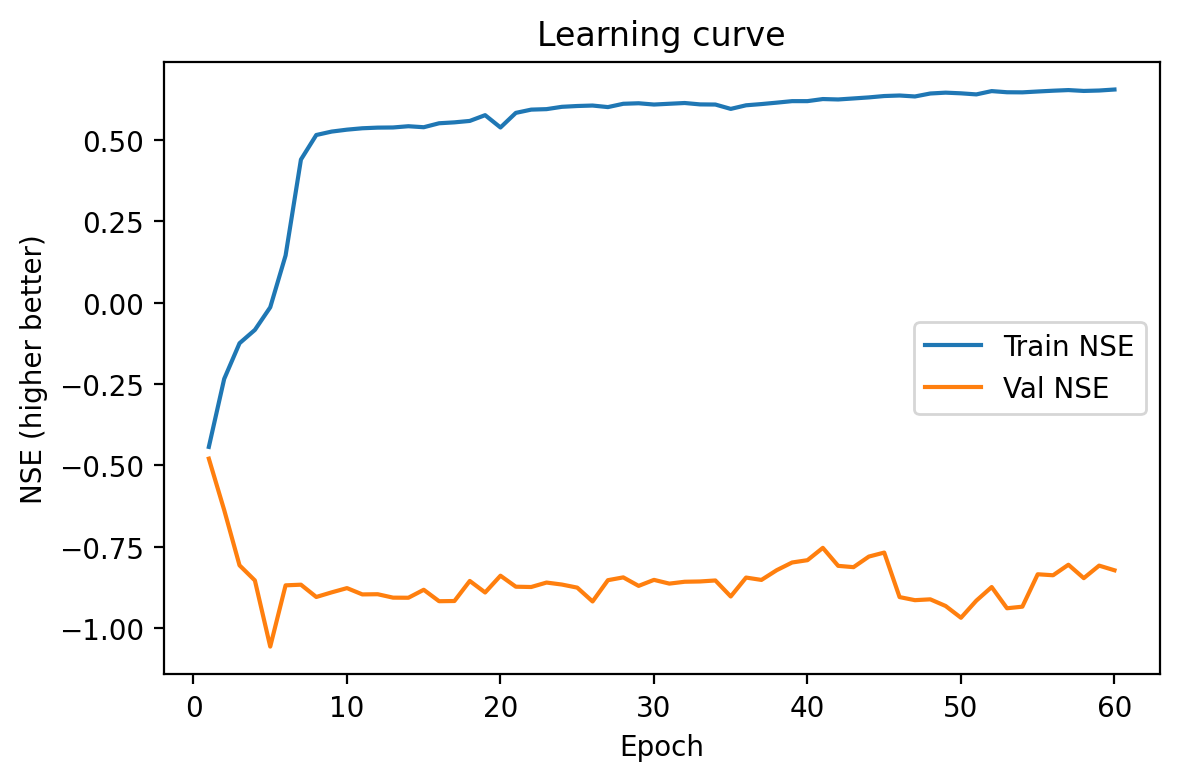

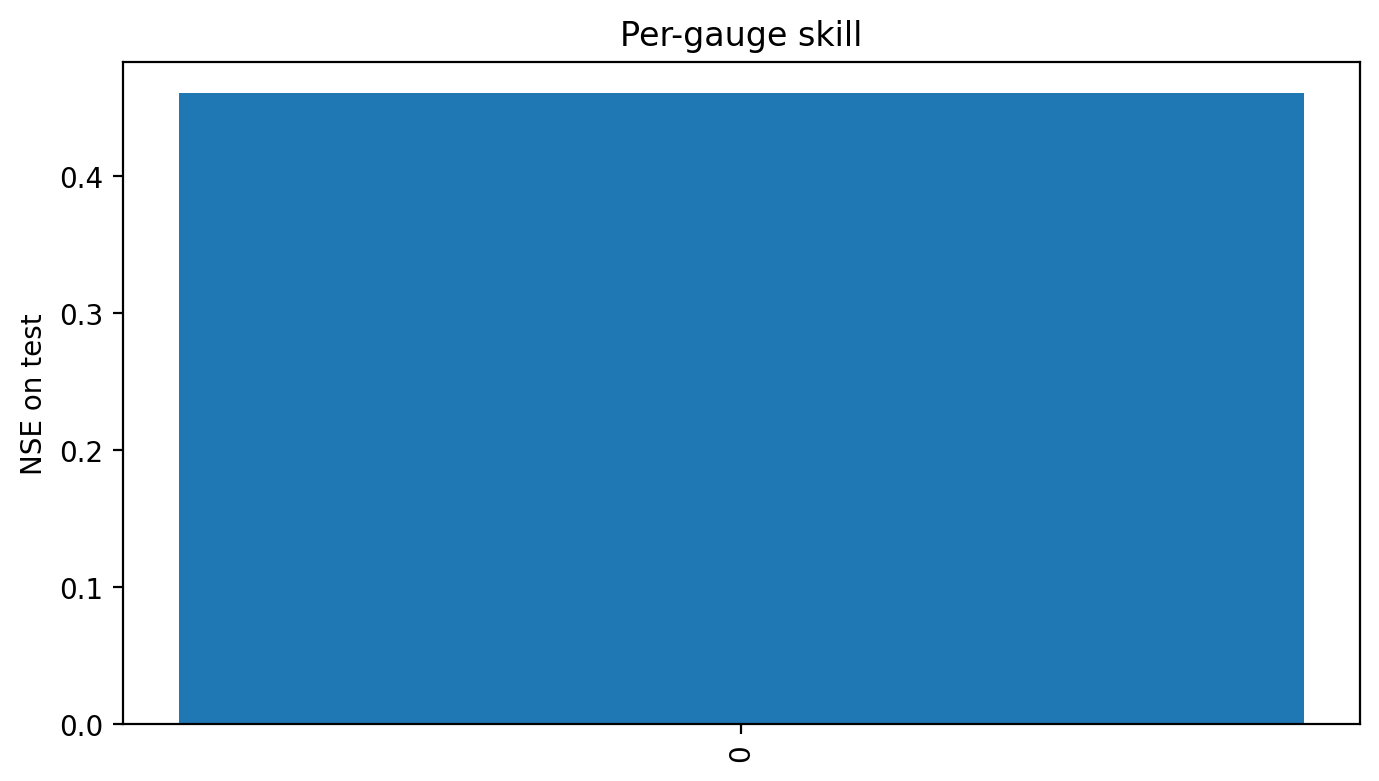

In [18]:
# ------------------------------------------------------------------ 1. loss curve
hist = pd.read_json("checkpoints/history.json")

plt.figure(figsize=(6, 4))
plt.plot(hist.epoch, -hist.train, label="Train NSE")
plt.plot(hist.epoch, -hist.val, label="Val NSE")
plt.xlabel("Epoch")
plt.ylabel("NSE (higher better)")
plt.title("Learning curve")
plt.legend()
plt.tight_layout()
plt.savefig("checkpoints/curve.png", dpi=150)

# ------------------------------------------------------------------ 2. gauge NSE

metrics.sort_values("NSE", inplace=True)

plt.figure(figsize=(7, 4))
plt.bar(metrics.gauge.astype(str), metrics.NSE)
plt.xticks(rotation=90, ha="center")
plt.ylabel("NSE on test")
plt.title("Per-gauge skill")
plt.tight_layout()
plt.savefig("checkpoints/per_gauge_nse.png", dpi=150)
